# Bayesian Data Analysis - project work 2019

#### Ali Salloum & Oskari Lehtonen

### Content

#### 1. Introduction to our project
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I. Our problem
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; II. Our data
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; III. Data preprocessing
#### 2. The pooled model
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I. The description of model
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; II. Stan-model
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; III. Running the Stan-model
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; IV. Convergence diagnostics
#### 3. The hierarchial model
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I. The description of model
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; II. Stan-model
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; III. Running the Stan-model
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; IV. Convergence diagnostics
#### 4. Comparing the models 
#### 5. Conclusion
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I. Potential improvements
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; II. Main findings

______________________________________________________________________________________________________

---------------------------

## 1. Introduction to our project

### I. Our problem

The World Health Organization (WHO) reports annually the life expectancies of each its regions. 

"Life expectancy at birth reflects the overall mortality level of a population. It summarizes the mortality pattern that prevails across all age groups in a given year – children and adolescents, adults and the elderly." (WHO)

The Organisation for Economic Co-operation and Development (OECD) reminds us that gains in life expectancy at birth can be connected to a several factors, including rising living standards, improved lifestyle and better education, as well as greater access to quality health services. Therefore, modeling the global life expectancy mathematically could reveal the general trend on our globe. Especially the hierarchical approach could help us to estimate the *superpopulation* of which each WHO-region has obtained their values. The underlying population could let us truly monitor the general trend globally, and conclude how fairly the positive changes are spread and distributed.

In this project, we are trying out two different models: **The pooled model** which treats all WHO-regions the same and **The hierarchical model** which considers the parameters of each region as a sample from a superpopulation. The latter is an intermediate solution where the level of pooling is determined by the data and a prior on the amount of pooling. The main task is to **model the varying slopes and intercepts of each region** and **estimate the underlying superpopulation** that let us make inferences on other regions and globally.

We perform the same tricks, plots and diagnostics for both models in their own sections. The final model comparision occurs in the section 4. The mathematical formulations for both models are also described later in the notebook. In the last section we list the main findings and potential improvements.

### II. Our data

Our main goal during the project was to focus on the methodology and bayesian framework. We decided to keep the number of variables low in order study the behaviour of our parameters more visually and invest our time in careful and effective implementation. The models below are easily generalized to multidimensional case.

The data set is provided by WHO and it can be found here: http://apps.who.int/gho/data/node.main.

Data set is 30x5 matrix and the columns were the year, WHO-region and the life expectancies at birth for male, female and both sexes. Our data points were from the years of:
- 2000, 2005, 2010, 2015 and 2016. 

The WHO-regions that are included in the data set are the following: 
- Africa, Europe, Americas, Eastern Mediterranean, South-East Asia, Western Pacific.

The descriptive statistics of our data are introduced in the next section. Other relevant information on the data (directly copied from data source):

- Rationale:
Life expectancy at birth reflects the overall mortality level of a population. It summarizes the mortality pattern that prevails across all age groups - children and adolescents, adults and the elderly.

- Definition:
The average number of years that a newborn could expect to live, if he or she were to pass through life exposed to the sex- and age-specific death rates prevailing at the time of his or her birth, for a specific year, in a given country, territory, or geographic area.

- Method of measurement
Life expectancy at birth is derived from life tables and is based on sex- and age-specific death rates. Life expectancy at birth values from the United Nations correspond to mid-year estimates, consistent with the corresponding United Nations fertility medium-variant quinquennial population projections.

- Preferred data sources:
Civil registration with complete coverage


### III. Data preprocessing

In [46]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import arviz as az
import pystan
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df_original = pd.read_csv("data/data.csv")
df_original = df_original.rename(columns=df_original.iloc[0])
df = df_original.drop(df_original.index[0])

# Convert the data types
df["Year"] = df["Year"].astype(int)
df["Male"] = df["Male"].astype(float)
df["Female"] = df["Male"].astype(float)
df["Both sexes"] = df["Both sexes"].astype(float)

# Quick glance at our data
df.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
Year,30.0,2009.2,6.1,2000.0,2005.0,2010.0,2015.0,2016.0
Both sexes,30.0,69.6,7.3,50.8,65.7,71.0,75.6,77.5
Male,30.0,67.4,6.7,49.6,64.5,68.2,72.6,75.0
Female,30.0,67.4,6.7,49.6,64.5,68.2,72.6,75.0


## 2. The pooled model

### I. The description of model

**The model**

Pooled regression model is one type of model that has constant coefficients, referring to both intercepts and slopes. Formally,

$$ y_{n} = \beta_{}x_{n} + \alpha + \epsilon_n \quad \text{where} \quad \epsilon_n \sim \text{N}(0, \sigma^2)$$

The same model can be also written as 
$$ y_{n} \sim \text{N}(\beta_{}x_{n} + \alpha, \sigma^2) $$

*Note that the stan model uses the deviation as the second parameter - not the variance.*

**The prior choices**

- Scenario I. (*This one was selected*)

$$\beta \sim \text{N}(0, \tau^2) \quad \text{where} \quad  \tau = 16$$

Reasoning: It is very unlikely that the mean life expectancy would change more than 50 % in one year. The prior above bounds the rate to have $\text{P}(-\frac{69.6}{2} \leq \tau \leq \frac{69.6}{2} = 0.99)$.

- Scenario II.

$$\beta \sim \text{N}(0, \tau^2) \quad \text{where} \quad  \tau = 26$$

Reasoning: For the sensitivity analysis, we let the increase or decrease per year be even larger than 50%.

- Scenario III.

Reasoning: The noninformative or flat prior, which is equivalent to uniform prior on the parameter. This prior was also set for sensitivity analysis purposes.

### II. Stan-model

In [221]:
the_pooled_model = """
    data {
        int<lower=0> N;
        vector[N] x;          
        vector[N] y;
        real xpred;
        real tau;  // prior std for beta
    } 
    parameters {
        real alpha;              // intercept
        real beta;               // slopes of vars
        real<lower=0> sigma;     // total error
    }
    model{
        beta ~ normal(0, tau); // Beta parameter prior-distribution
        alpha ~ normal(-600, 100);
        sigma ~ normal(0, 10); // error 
        y ~ normal(alpha + beta*x, sigma);
    }
    generated quantities {
        vector[N] yrep;
        real ypred;
        
        for (n in 1:N) {
            yrep[n] = normal_rng(alpha + beta*x[n], sigma);
        }
        
        // predict the life expectancy for the year 2020 
        ypred = normal_rng(alpha + beta*xpred, sigma);
    }

"""

### III. Running the Stan-model

In [222]:
# Input the data properly
pooled_data_dict = {}
pooled_data_dict["N"] = len(df["Year"])
pooled_data_dict["x"] = np.asarray(df["Year"].values, dtype=int)
pooled_data_dict["y"] = np.asarray(df["Both sexes"].values, dtype=float)
pooled_data_dict["xpred"] = 2020
pooled_data_dict["tau"] = 16

In [223]:
# Run the stan model
pooled_fit = pystan.stan(
    model_code = the_pooled_model,
    data = pooled_data_dict, 
    iter = 2000, 
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a02badcec94ac6be0a6ec418d3cbbb22 NOW.


### IV. Convergence diagnostics

In [224]:
print(pooled_fit.stansummary(pars=['sigma', 'alpha', 'beta', 'ypred']))

Inference for Stan model: anon_model_a02badcec94ac6be0a6ec418d3cbbb22.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   7.24    0.03   1.01   5.63   6.53   7.11   7.83   9.57   1079   1.01
alpha -605.4    3.04  98.83 -800.6 -670.4 -606.4 -541.8 -407.8   1059    1.0
beta    0.34  1.5e-3   0.05   0.24    0.3   0.34   0.37   0.43   1060    1.0
ypred  73.19    0.12   7.43  58.48  68.22  73.34  78.11  87.52   3816    1.0

Samples were drawn using NUTS at Sun Dec  8 19:04:02 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


**Rhat** The $\hat R$ statistic measures the ratio of the average variance of draws within each chain to the variance of the pooled draws across chains; if all chains are at equilibrium, these will be the same and R^ will be one. The Rhat values are required to be less than 1.05 to justify convergence of the draws. [1]

**ESS** is an estimate of the sample size required to achieve the same level of precision if that sample was a simple random sample. Since the inference of bayesian models is based on the posterior draws and the MCMC process causes the draws to be correlated, the ESS is usually lower than the actual number of draws. Now the higher the effective sample size the more likely the chains for the draws have converged. It is stated in stan documentation that the bulk ESS should be atleast 100 times the number of chains. [2] 

The Rhat values for each of the parameters is equal to 1 and the ESS values clearly exceed the 100*n_chains criteria as can be seen from the prints above and plots below. In fact during posterior draws he ESS never falls below the thin vertical line which is considered to be the minimum for convergence. Also the trace plots (which are time series plots of the Markov chains) seem reasonable and just by eyeballing them the convergence seems obivous. Based on these, it is clear that the model has converged properly.

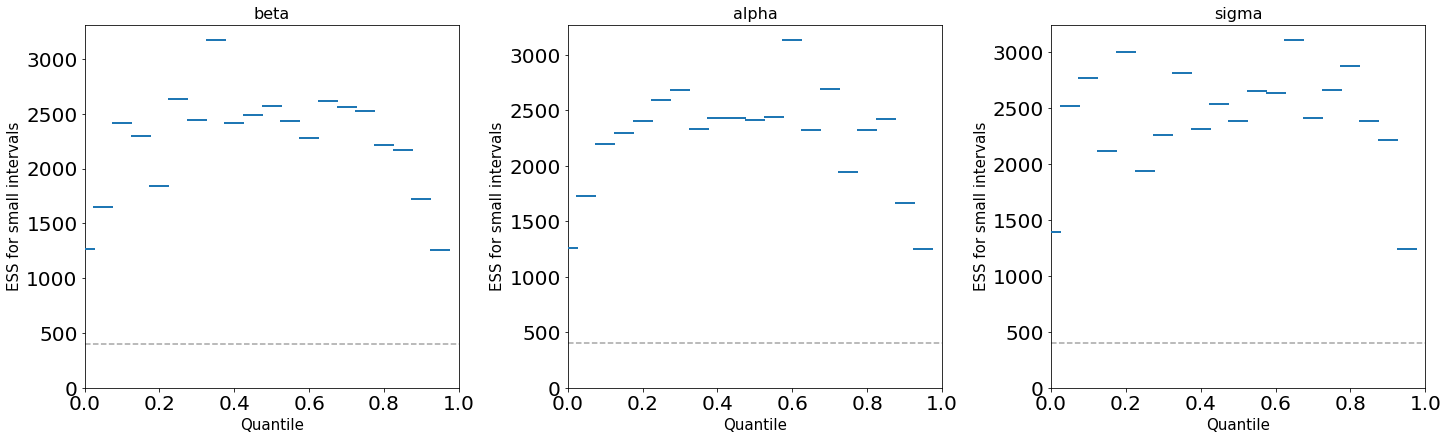

In [225]:
_ = az.plot_ess(
    pooled_fit, var_names=["beta", "alpha", "sigma"], 
    kind="local", marker="_", ms=20, mew=2, figsize=(20, 6)
)

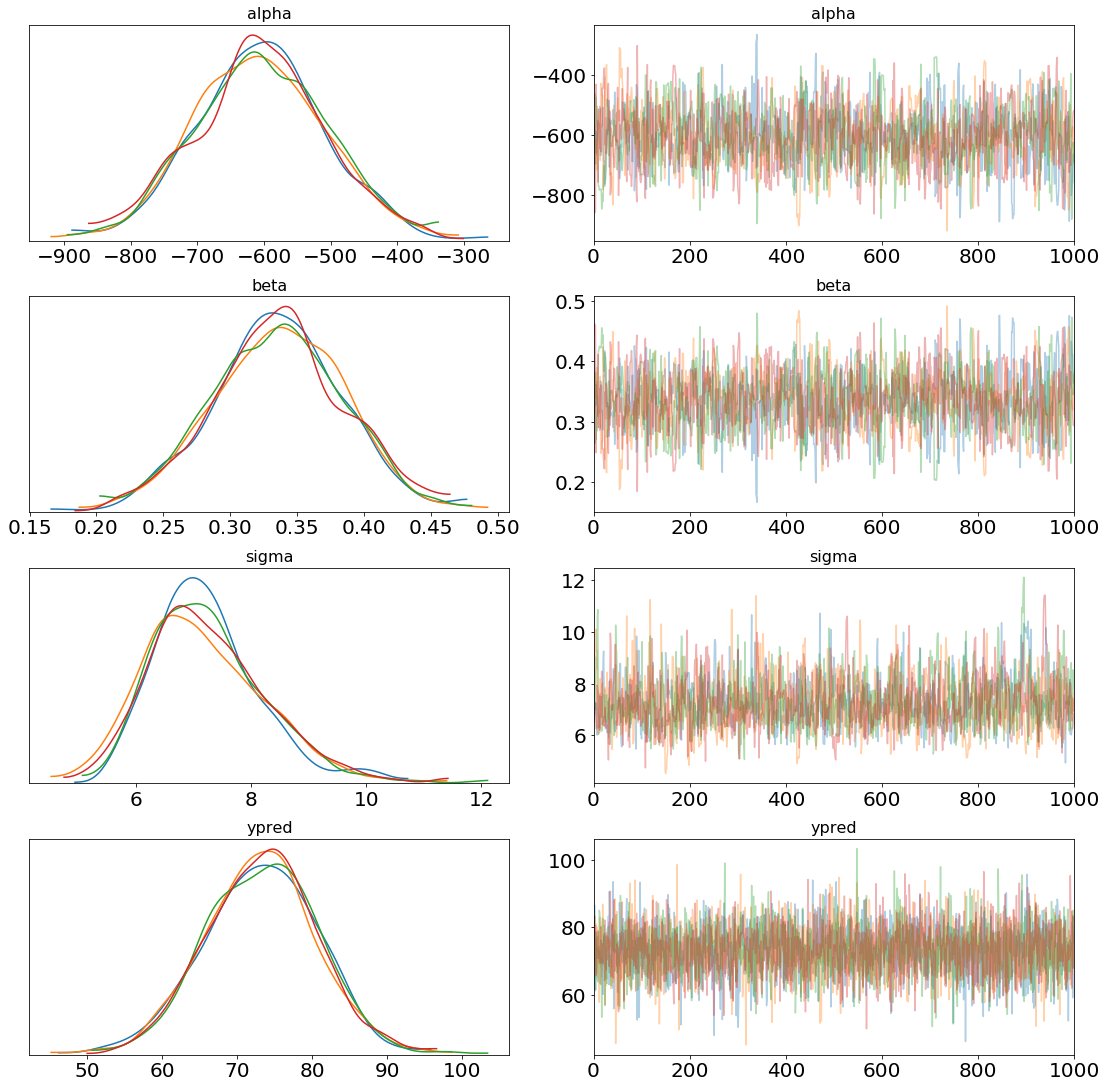

In [226]:
_ = az.plot_trace(pooled_fit, var_names = ["alpha", "beta", "sigma", "ypred"], figsize=(15, 15))

**HMC Specific diagnostics**

In [227]:
p = pooled_fit.to_dataframe(diagnostics=True)
print('quantiles treedepth for draws:\n', p['treedepth__'].quantile([0, 0.25, 0.5, 0.75, 1]))
print('divergent transitions: ', any(p['divergent__']))

quantiles treedepth for draws:
 0.00    1.0
0.25    6.0
0.50    8.0
0.75    8.0
1.00    9.0
Name: treedepth__, dtype: float64
divergent transitions:  False


### V. Posterior predictive checking & Predictive performance

From the plot below, we demonstrate this by plotting the posterior prediction distribution for 2020. It can be seen from the plot that these predictions vary extensively. We also plot the $y_{rep}$ data distributions simulated from the posterior predictive distribution that are used for the $R^2$ calculation. We clearly see that the deviance of the posterior repetitive distributions is also very large, meaning that the predictive performance is not robust. The $R^2$-value, that should be close to 1 for a good fit, is also presented and this indicates a poor predictive performance for the model. However, the pooled model is good at giving predictions for the global life expectancy where no differences among regions is taken into account. In fact, the mean of the predictive distribution for the global life expectancy in 2020 is less than one year away from the global life expectancy prediction provided by UN DESA (United Nations Department of Economic and Social Affairs). [3]

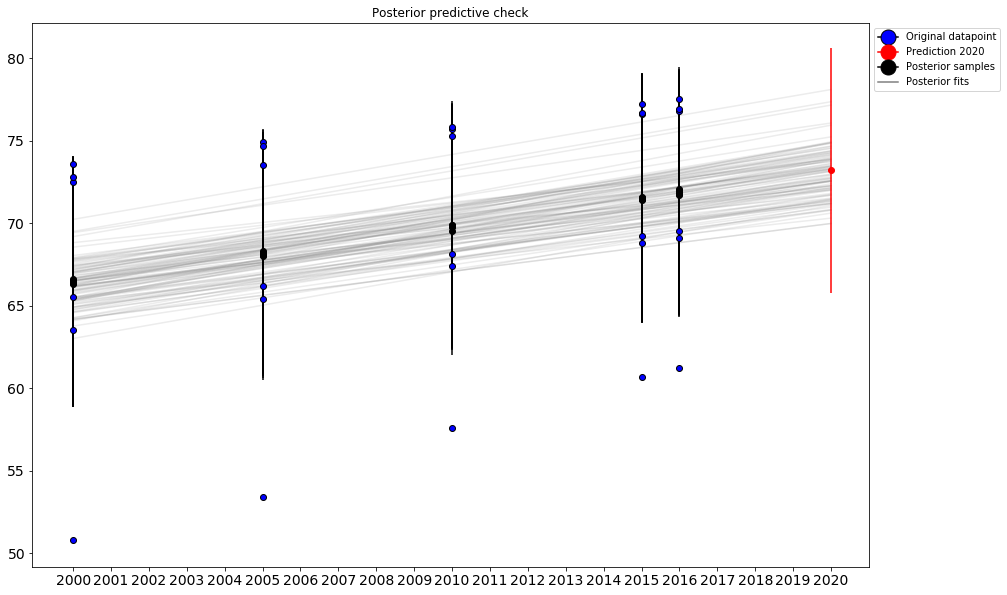

In [228]:
# Plot posterior predictive checks
b = pooled_fit.to_dataframe()
plt.figure(figsize=(15,10))
vuosi = np.linspace(2000, 2020)
y = np.mean(pooled_fit["beta"]) * vuosi + np.mean(pooled_fit["alpha"])

for i in range(100):
    y = pooled_fit["beta"][i] * vuosi + pooled_fit["alpha"][i]
    _ = plt.plot(vuosi, y, zorder=i, color='gray', alpha=0.15)
    
for j in reversed(range(1, 31)):
    yrep = pooled_fit['yrep[{}]'.format(j)] 
    _ = plt.errorbar(
        x = pooled_data_dict["x"][j-1], 
        y = np.mean(yrep), 
        yerr=np.std(yrep), 
        fmt='--o', zorder=i+j,
        ecolor='black', capthick=2,
        color='black',
    )
    
ypred = pooled_fit['ypred'] 
_ = plt.errorbar(
    x = 2020, 
    y = np.mean(ypred), 
    yerr=np.std(ypred), 
    fmt='--o', zorder=i+j+100,
    ecolor='red', capthick=2,
    color='red',
)
    
_ = plt.scatter(
    pooled_data_dict["x"], pooled_data_dict["y"], 
    zorder=j+i+100, edgecolors='black', color='b'
)
_ = plt.title("Posterior predictive check")

custom_legends = [
    Line2D(
        [0], [0], marker='o', color='black',markerfacecolor='b',  
        label='Original datapoint', markersize=15
    ),
    Line2D(
        [0], [0], marker='o', color='red', 
        label='Prediction 2020', markersize=15
    ),
    Line2D(
        [0], [0], marker='o', color='black',
        label='Posterior samples', markersize=15
    ),
    Line2D(
        [0], [0], color='gray',
        label='Posterior fits', markersize=15
    ),
    
]

_ = plt.legend(handles=custom_legends, bbox_to_anchor=(1, 1))
_ = plt.xticks(np.arange(2000, 2021), fontsize=14)
_ = plt.yticks(fontsize=14)

In [178]:
az.r2_score(pooled_data_dict["y"], np.mean(pooled_fit["yrep"], axis=0))

r2        0.081501
r2_std    0.000000
dtype: float64

### VI. Sensitivity analysis

As can be seen from the ridge plots below. The model seems to be robust with different prior choices for beta since there is no clear deviation in the posterior distributions with different models. Also
based on the R_hat values (all are equal to 1), all the models seem to converge just fine. Interestingly though, the ESS is the highest for the model with uniform prior. So based on this the convergence is best when the beta prior is set to non-informative uniform prior. However the other prior choices had ESS values of sufficient size also and there is no reason to believe that there were problems with the convergence of the models.

In [14]:
# Run pooled stan model with different beta priors
# uniform, normal(0, sigma=tau=16), normal(0, sigma=tau=26)
pooled_fit_uniform = pystan.stan(
    model_code = the_pooled_model, 
    data = pooled_data_dict, 
    iter = 2000, 
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3cbd2d246f0c93df4bdd14ca957978bd NOW.


In [17]:
pooled_fit_tau26 = pystan.stan(
    model_code = the_pooled_model, 
    data = pooled_data_dict, 
    iter = 2000, 
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2871ff4c7436b3038a45adf7fe8bbcd1 NOW.


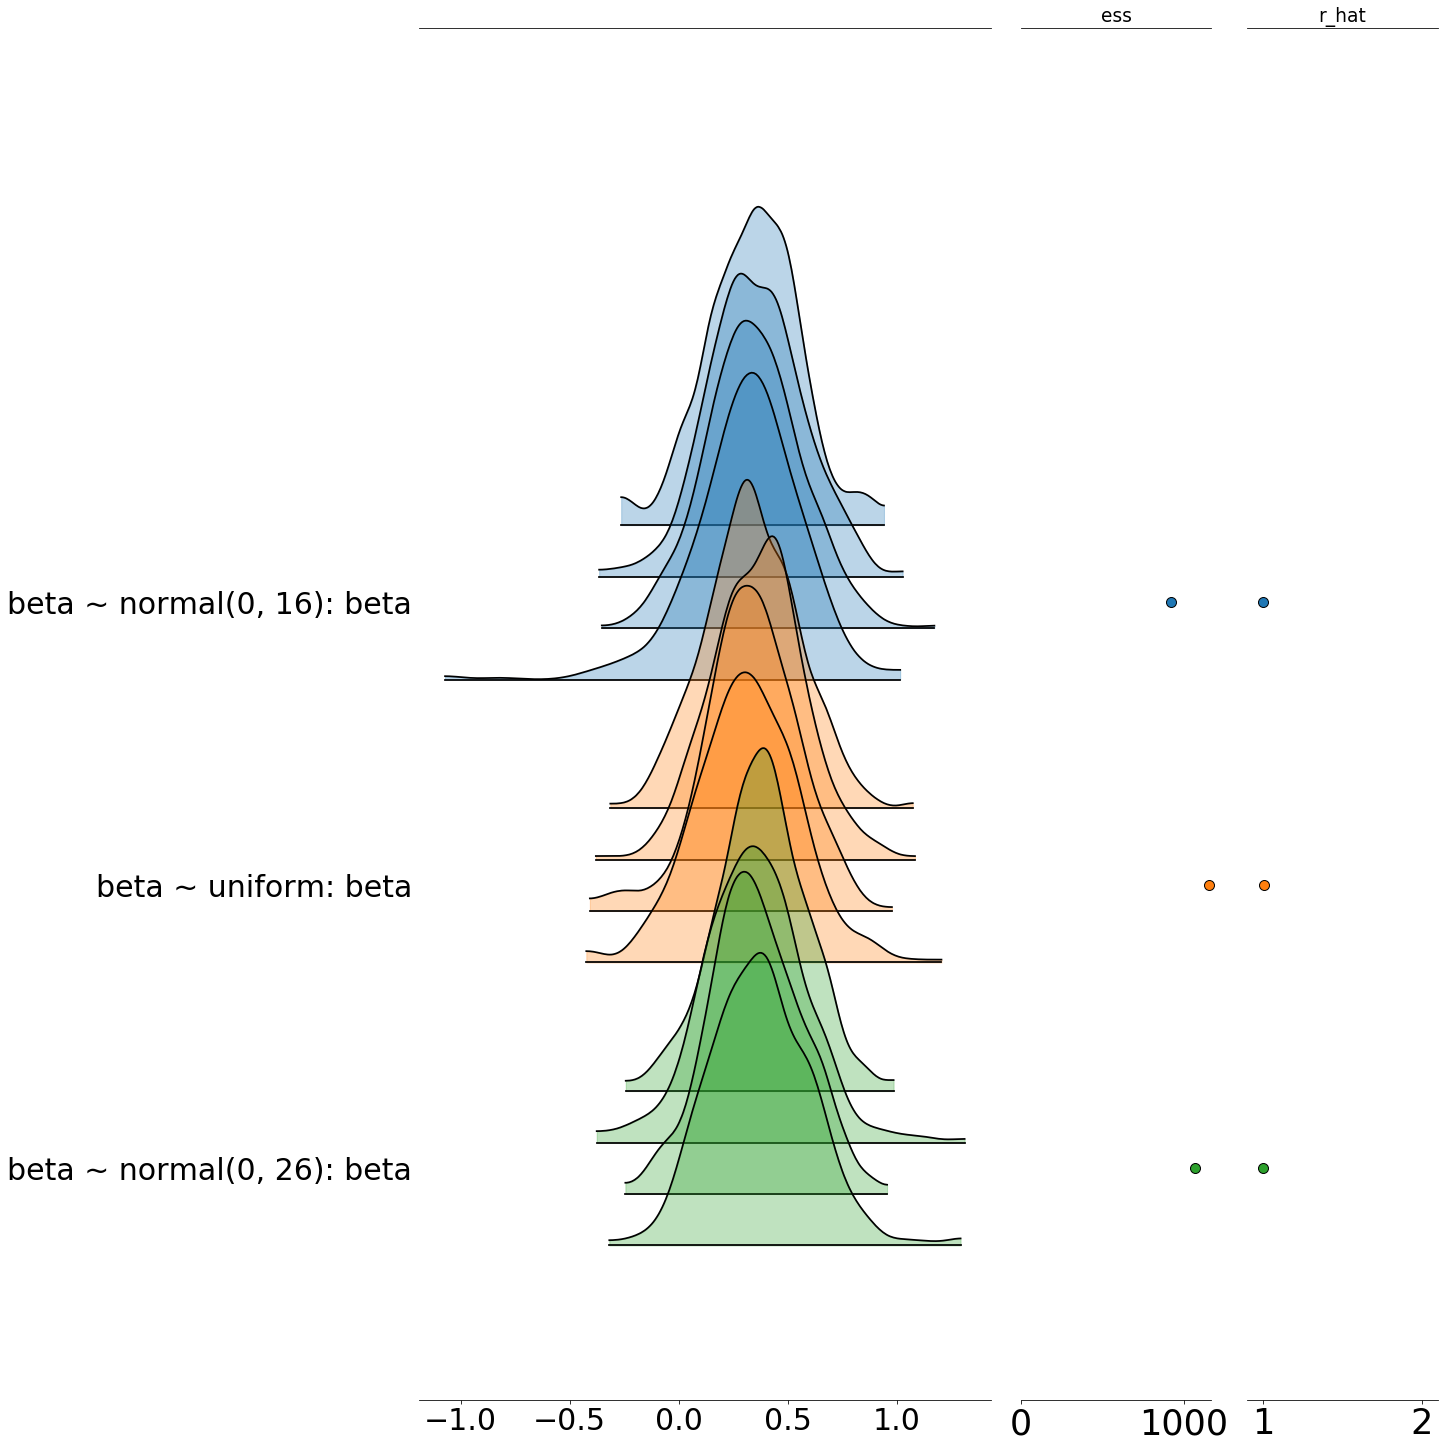

In [197]:
_ = az.plot_forest(
    [pooled_fit, pooled_fit_uniform, pooled_fit_tau26], 
    model_names=["beta ~ normal(0, 16)", "beta ~ uniform", "beta ~ normal(0, 26)",], var_names=["beta"], markersize=10,
    kind='ridgeplot', ridgeplot_overlap=3, ridgeplot_alpha=0.3, r_hat=True, ess=True, figsize=(20, 20), textsize=35
)

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.savefig('sensitivity_pooled.png')

## 3. The hierarchical model

### I. The description of model

**The model**

By using the hierarchical model, we are able to consider the natural hierarchical structure of observed data. We believe that both rate and the baseline between the continents vary. This model lets slopes and the intersects vary on group-level. On the other hand, modeling each continent separately might be too radical. A hierarchical model is an intermediate solution where the level of pooling is determined by the data and a prior on the amount of pooling.

$$y_{nj} = \alpha_{j}+\beta_{j}x_{nj}+\epsilon_{nj}$$

$y_{nj}$ refers to the life expectancy on the dependent variable (year) for an individual observation at level 1.

$x_{nj}$ refers to the level 1 predicator.

$\alpha_{j}$ refers to the intercept of the dependent variable in group $j$.

$\beta_{j}$ refers to the slope for the relationship in group $j$ between the level 1 predictor.

$\epsilon_{ij}$ represents the random errors of prediction for the level 1 equation.

**The prior choices**

We will be modelling both the intercept and slope parameters with normal distributions. However, since this model is hierarchically grouped to regions, the groups will be sharing priors for both of the parameters. 

The slope parameter's normal distribution has a standard deviation distributed according to a $X \sim Scale-inv-\chi^2(\nu, \tau^2)$ (scaled inverse chi squared distribution) with parameters $\nu = 4$ and $\tau^2 = 1$. This prior restricts the standard deviation to be positive. While most of the mass of this distribution is around 1, the tail of the distribution is still fat enough to allow enough deviance from this value. The distribution still restricts the group level variance in slopes to be quite small which is desired because the slopes should not deviate drastically between groups. The mean for the slope distribution is identical to the pooled model and the same justification apply here as well (refer to section 2.I).

The intercept parameter's normal distribution has a standard deviation distributed according to $X \sim Cauchy(x_0, \gamma)$ that is centered at zero and the parameter $\gamma = 10$. This gives out a wide range of possible values for the deviation of the intercept which is desired since the group level variance in intercepts is quite large between groups. The mean comes from a normal distribution centered at zero and $\sigma = 10$. This is a vague prior and used only to make sure there is enough deviance between posterior samples.

All the priors work as weakly-informative ones. This can be verified when we run the model. It can be seen that the priors do not restrict the parameter values too much but they still provide enough structure to the model.

The **sensitivity analysis** was conducted with the same approach as with the pooled model. so the same prior $\beta$ for each group was changed in an identical manner (refer to section 2.I).

### II. Stan-model

In [47]:
the_hier_model = """
    data {                                 
        int<lower=0> N;
        vector[N] x;
        vector[N] y;
        int<lower=0> n_region;  
        int<lower=1, upper=n_region> region_enc[N]; 
        real xpred;
        real tau;
    }
    parameters {
        real<lower=0> sigma;      
        real global_mu_alpha;
        real<lower=0> global_sd_alpha;
        real global_mu_beta;
        real<lower=0> global_sd_beta;
        
        vector[n_region] alpha_region;        
        vector[n_region] beta_region;
    }

    model {  
        
        global_mu_alpha ~ normal(0, 10);
        global_sd_alpha ~ cauchy(0, 10);        
        
        global_mu_beta ~ normal(0, tau);     
        global_sd_beta ~ scaled_inv_chi_square(4, 1);
     
        for (c in 1:n_region) {
              alpha_region[c]~ normal(global_mu_alpha, global_sd_alpha);
              beta_region[c] ~ normal(global_mu_beta, global_sd_beta);
        }
        
        sigma ~ normal(0, 10);  // prior for error
        y ~ normal(alpha_region[region_enc] + beta_region[region_enc].*x, sigma);
    }
    generated quantities {
        matrix[N, n_region] yrep;
        vector[n_region] ypred;
        for (k in 1:n_region) {
            for(n in 1:N) {
                yrep[n, k] = normal_rng(alpha_region[k] + beta_region[k]*x[n], sigma);
            }
            ypred[k] = normal_rng(alpha_region[k] + beta_region[k]*xpred, sigma);
        }
        
    }
    
"""

### III. Running the Stan-model

In [49]:
# Input the data properly
hier_data_dict = {}
hier_data_dict["N"] = 30
hier_data_dict["x"] = np.asarray(df["Year"].values, dtype=int)
hier_data_dict["y"] = np.asarray(df["Both sexes"].values, dtype=float)
hier_data_dict["n_region"] = 6
hier_data_dict["xpred"] = 2020
hier_data_dict["tau"] = 16

# Region encoding
region = df["WHO region"]
region = region.replace("Africa", 1)
region = region.replace("Americas", 2)
region = region.replace("South-East Asia", 3)
region = region.replace("Europe", 4)
region = region.replace("Eastern Mediterranean", 5)
region = region.replace("Western Pacific", 6)
hier_data_dict["region_enc"] = region

In [50]:
# Run the stan model
hier_fit = pystan.stan(
    model_code = the_hier_model, 
    data = hier_data_dict, 
    iter = 4000, 
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0579b78437fdbb935fc466821f0aa85d NOW.


### IV. Convergence diagnostics

Identically to the pooled model, the **Rhat** values for each of the parameters is equal to 1 and the **ESS** values clearly exceed the 100*n_chains criteria. Similarlrly to the pooled model, the ESS never falls below the thin vertical line which is the minimum for convergence. Also the trace plots seem reasonable and just by eyeballing them the convergence seems obivous. Again, based on these, it is clear that the model has converged properly.

In [132]:
print(hier_fit.stansummary(pars=['sigma', 'alpha_region', 'beta_region']))

Inference for Stan model: anon_model_0579b78437fdbb935fc466821f0aa85d.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma             0.31  9.4e-4   0.06   0.22   0.27    0.3   0.34   0.45   3759    1.0
alpha_region[1]  -1281    0.61  47.71  -1373  -1312  -1281  -1249  -1186   6187    1.0
alpha_region[2] -309.2    0.57  46.72 -400.6 -339.5 -309.4 -279.4 -214.5   6642    1.0
alpha_region[3] -687.8    0.58  46.16 -782.1 -717.0 -688.2 -657.3 -597.0   6322    1.0
alpha_region[4] -577.2    0.59  46.56 -669.4 -606.7 -578.2 -547.0 -484.5   6205    1.0
alpha_region[5] -401.0    0.56  47.57 -494.4 -431.1 -400.7 -370.0 -306.2   7206    1.0
alpha_region[6] -416.0    0.56  46.02 -507.2 -446.0 -415.8 -386.1 -324.5   6854    1.0
beta_region[1]    0.67  3.0e-4   0.02   0.62   0.65   0.67   0.68   0.71   6185    1.0
beta_region[2]    0.19  2.9e

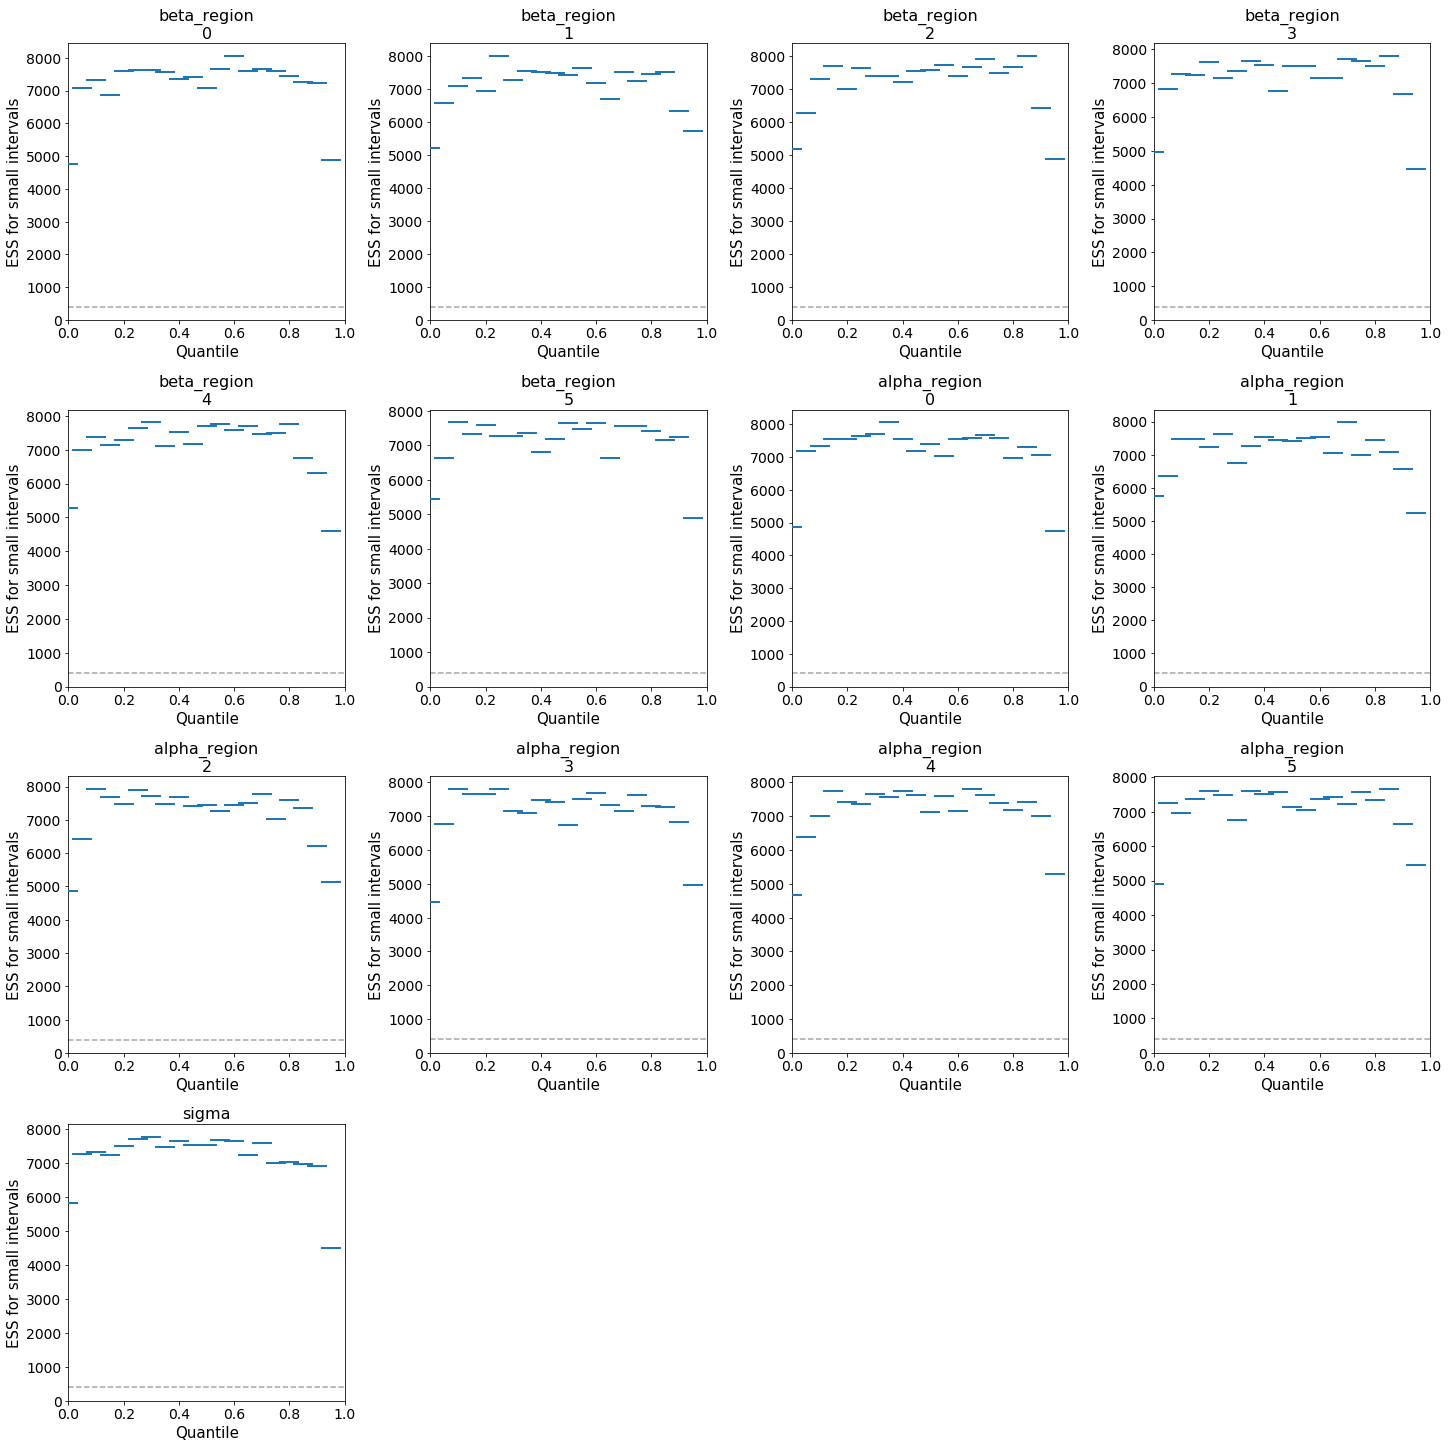

In [129]:
_ = az.plot_ess(
    hier_fit, var_names=["beta_region", "alpha_region", "sigma"], 
    kind="local", marker="_", ms=20, mew=2, figsize=(20, 20)
)

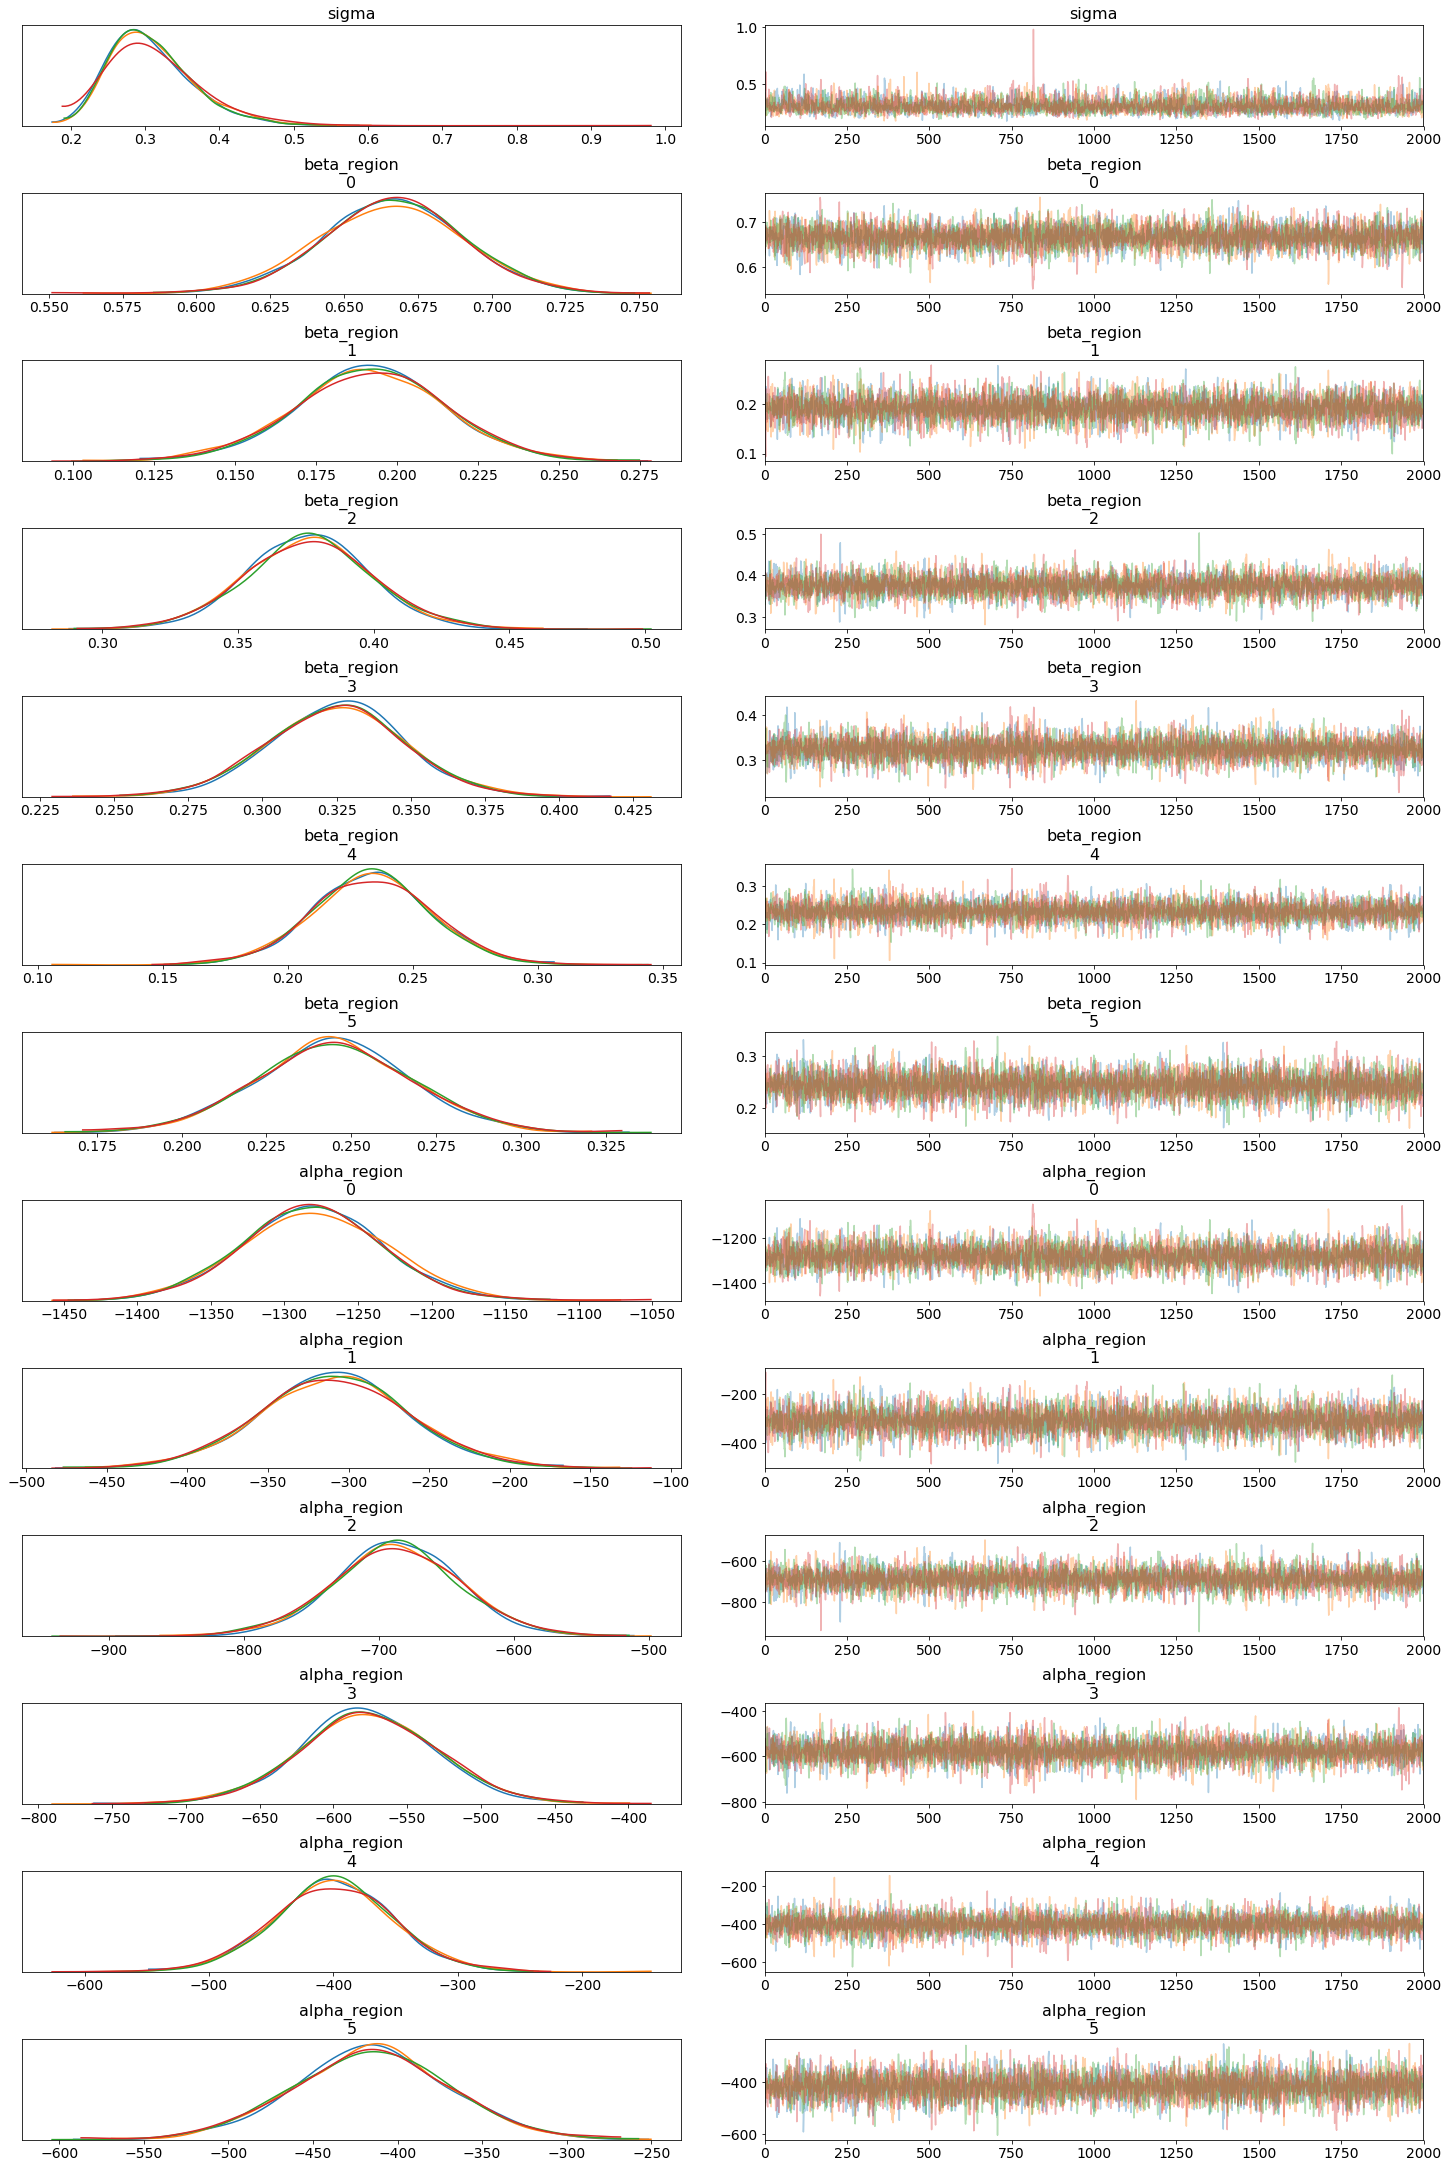

In [105]:
_ = az.plot_trace(hier_fit, var_names = ["sigma", "beta_region", "alpha_region"], figsize=(20, 30))

**HMC specific diagnostics**

In [141]:
h = hier_fit.to_dataframe(diagnostics=True)
print('max treedepth for draws: ', h['treedepth__'].max())
print('min treedepth for draws: ', h['treedepth__'].min())
print('mean treedepth for draws: ', h['treedepth__'].mean())
print('divergent transitions: ', any(h['divergent__']))

max treedepth for draws:  13
min treedepth for draws:  2
mean treedepth for draws:  11.52225
divergent transitions:  False


### V. Posterior predictive checking & Predictive performance

From the plot below, we clearly see that the predictions for each group seem reasonable. Again we demonstrate this by plotting the prediction of life expectancy for each region in 2020. It can be seen from the plot that these are very reasonable predictions. Especially in comparison to the pooled model, where the deviance between different predictions is huge. We also plot the $y_{rep}$ data distributions simulated from the posterior predictive distribution that are used for the $R^2$ calculation. We clearly see that the deviance the posterior repetitive distributions is almost neglible, meaning that the predictive performance is a lot better with the hierarchical model. Below, the $R^2$-values are also presented and these too indicate a substantial increase in the predictive performance of the hierarchical model in comparison to the pooled model.

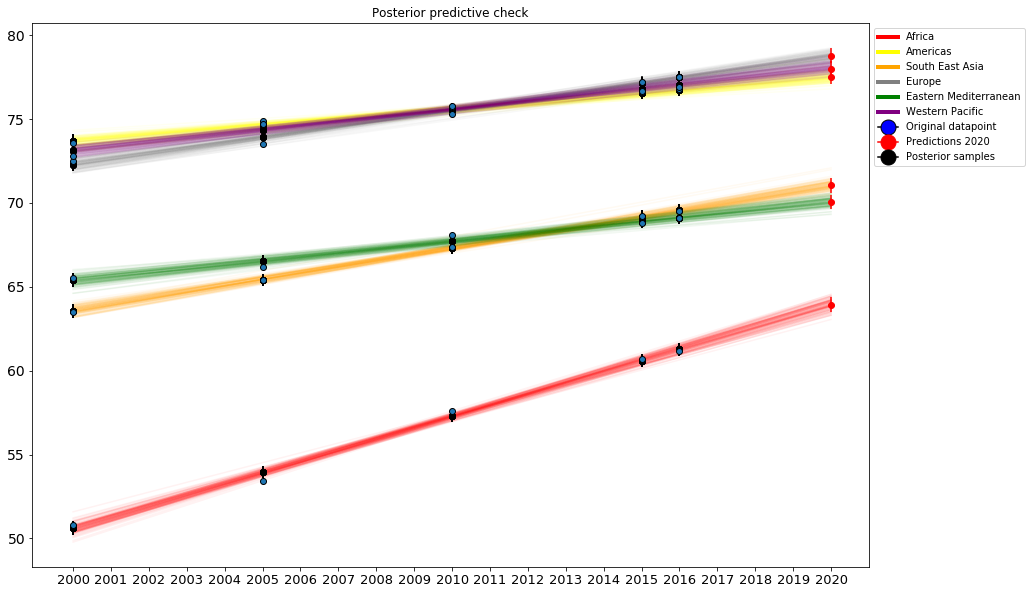

In [158]:
plt.figure(figsize=(15,10))
vuosi = np.linspace(2000, 2020)

colors = ['red', 'yellow', 'orange', 'gray', 'green', 'purple', 'pink']
for x in range(1, 7):
    print()
    for i in range(100):
        y = hier_fit["beta_region"][:, x-1][i] * vuosi + hier_fit["alpha_region"][:, x-1][i]
        _ = plt.plot(vuosi, y, color=colors[x-1], alpha=0.05)
    
for x in range(1, 7):
    for j in reversed(range(1, 31)):
        yrep = hier_fit['yrep[{},{}]'.format(j, x)]
        _ = plt.errorbar(
            x = hier_data_dict["x"][j-1], 
            y = np.mean(yrep), 
            yerr=np.std(yrep), 
            fmt='--o', zorder=i+j,
            ecolor='black', capthick=2,
            color='black',
        )

for k in range(1, 7):
    ypred = hier_fit['ypred[{}]'.format(k)] 
    _ = plt.errorbar(
        x = 2020, 
        y = np.mean(ypred), 
        yerr=np.std(ypred), 
        fmt='--o', zorder=i+j+100,
        ecolor='red', capthick=2,
        color='red',
    )
    
_ = plt.scatter(hier_data_dict["x"], hier_data_dict["y"], zorder=j+i+100, edgecolors='black')
_ = plt.title("Posterior predictive check")
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


custom_lines = [
    Line2D([0], [0], color='red', lw=4, label='Africa'),
    Line2D([0], [0], color='yellow', lw=4, label='Americas'),
    Line2D([0], [0], color='orange', lw=4, label='South East Asia'),
    Line2D([0], [0], color='gray', lw=4, label='Europe'),
    Line2D([0], [0], color='green', lw=4, label='Eastern Mediterranean'),
    Line2D([0], [0], color='purple', lw=4, label='Western Pacific'),
    Line2D([0], [0], marker='o', color='black', label='Original datapoint', markerfacecolor='b', markersize=15),
    Line2D([0], [0], marker='o', color='red', label='Predictions 2020', markersize=15),
    Line2D([0], [0], marker='o', color='black', label='Posterior samples', markersize=15),
    
]

_ = plt.legend(handles=custom_lines, bbox_to_anchor=(1, 1))
_ = plt.xticks(np.arange(2000, 2021), fontsize=13)
_ = plt.yticks(fontsize=14)

In [54]:
# R2 values
ytrue_africa = np.asarray(df[df["WHO region"] == "Africa"]["Both sexes"], dtype=float)
ytrue_americas = np.asarray(df[df["WHO region"] == "Americas"]["Both sexes"], dtype=float)
ytrue_easternmed = np.asarray(df[df["WHO region"] == "Eastern Mediterranean"]["Both sexes"], dtype=float)
ytrue_europe = np.asarray(df[df["WHO region"] == "Europe"]["Both sexes"], dtype=float)
ytrue_sea = np.asarray(df[df["WHO region"] == "South-East Asia"]["Both sexes"], dtype=float)
ytrue_wp = np.asarray(df[df["WHO region"] == "Western Pacific"]["Both sexes"], dtype=float)

In [55]:
yrep_matrix = np.mean(hier_fit["yrep"], axis = 0)

In [56]:
yrep_africa = np.mean(yrep_matrix[:,0].reshape(6,5), axis=0)
yrep_americas = np.mean(yrep_matrix[:,1].reshape(6,5), axis=0)
yrep_easternmed = np.mean(yrep_matrix[:,2].reshape(6,5), axis=0)
yrep_europe = np.mean(yrep_matrix[:,3].reshape(6,5), axis=0)
yrep_sea = np.mean(yrep_matrix[:,4].reshape(6,5), axis=0)
yrep_wp = np.mean(yrep_matrix[:,5].reshape(6,5), axis=0)

In [60]:
r2_africa = az.r2_score(ytrue_africa, yrep_africa)
r2_americas = az.r2_score(ytrue_americas, yrep_americas)
r2_easternmed = az.r2_score(ytrue_easternmed, yrep_easternmed)
r2_europe = az.r2_score(ytrue_europe, yrep_europe)
r2_sea = az.r2_score(ytrue_sea, yrep_sea)
r2_wp = az.r2_score(ytrue_wp, yrep_wp)
r2_dict = {
    'Africa':r2_africa,
    'Americas':r2_americas,
    'Eastern Mediterranean':r2_easternmed,
    'Europe':r2_europe,
    'South East Asia':r2_sea,
    'Western Pacific': r2_wp
}

In [89]:
pd.DataFrame(r2_dict)

,Africa,Americas,Eastern Mediterranean,Europe,South East Asia,Western Pacific
r2,0.994518,0.975711,0.866699,0.98769,0.723389,0.972576
r2_std,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


### VI. Sensitivity analysis

As can be seen from the forest plots for each group below. The model seems to be robust with different prior choices for different beta_regions, since there is no clear deviation in the posterior distributions with different models. Also
based on the R_hat and ESS values (all are equal to 1), all the models seem to converge just fine. 

In [41]:
hier_fit_uniform = pystan.stan(
    model_code = the_hier_model, 
    data = hier_data_dict, 
    iter = 4000, 
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aa0bd4275b46b3a4be5d1663cc5e04a4 NOW.


In [44]:
hier_fit_tau26 = pystan.stan(
    model_code = the_hier_model, 
    data = hier_data_dict, 
    iter = 4000, 
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c0bca25a0dae5f9349e823a83302d128 NOW.


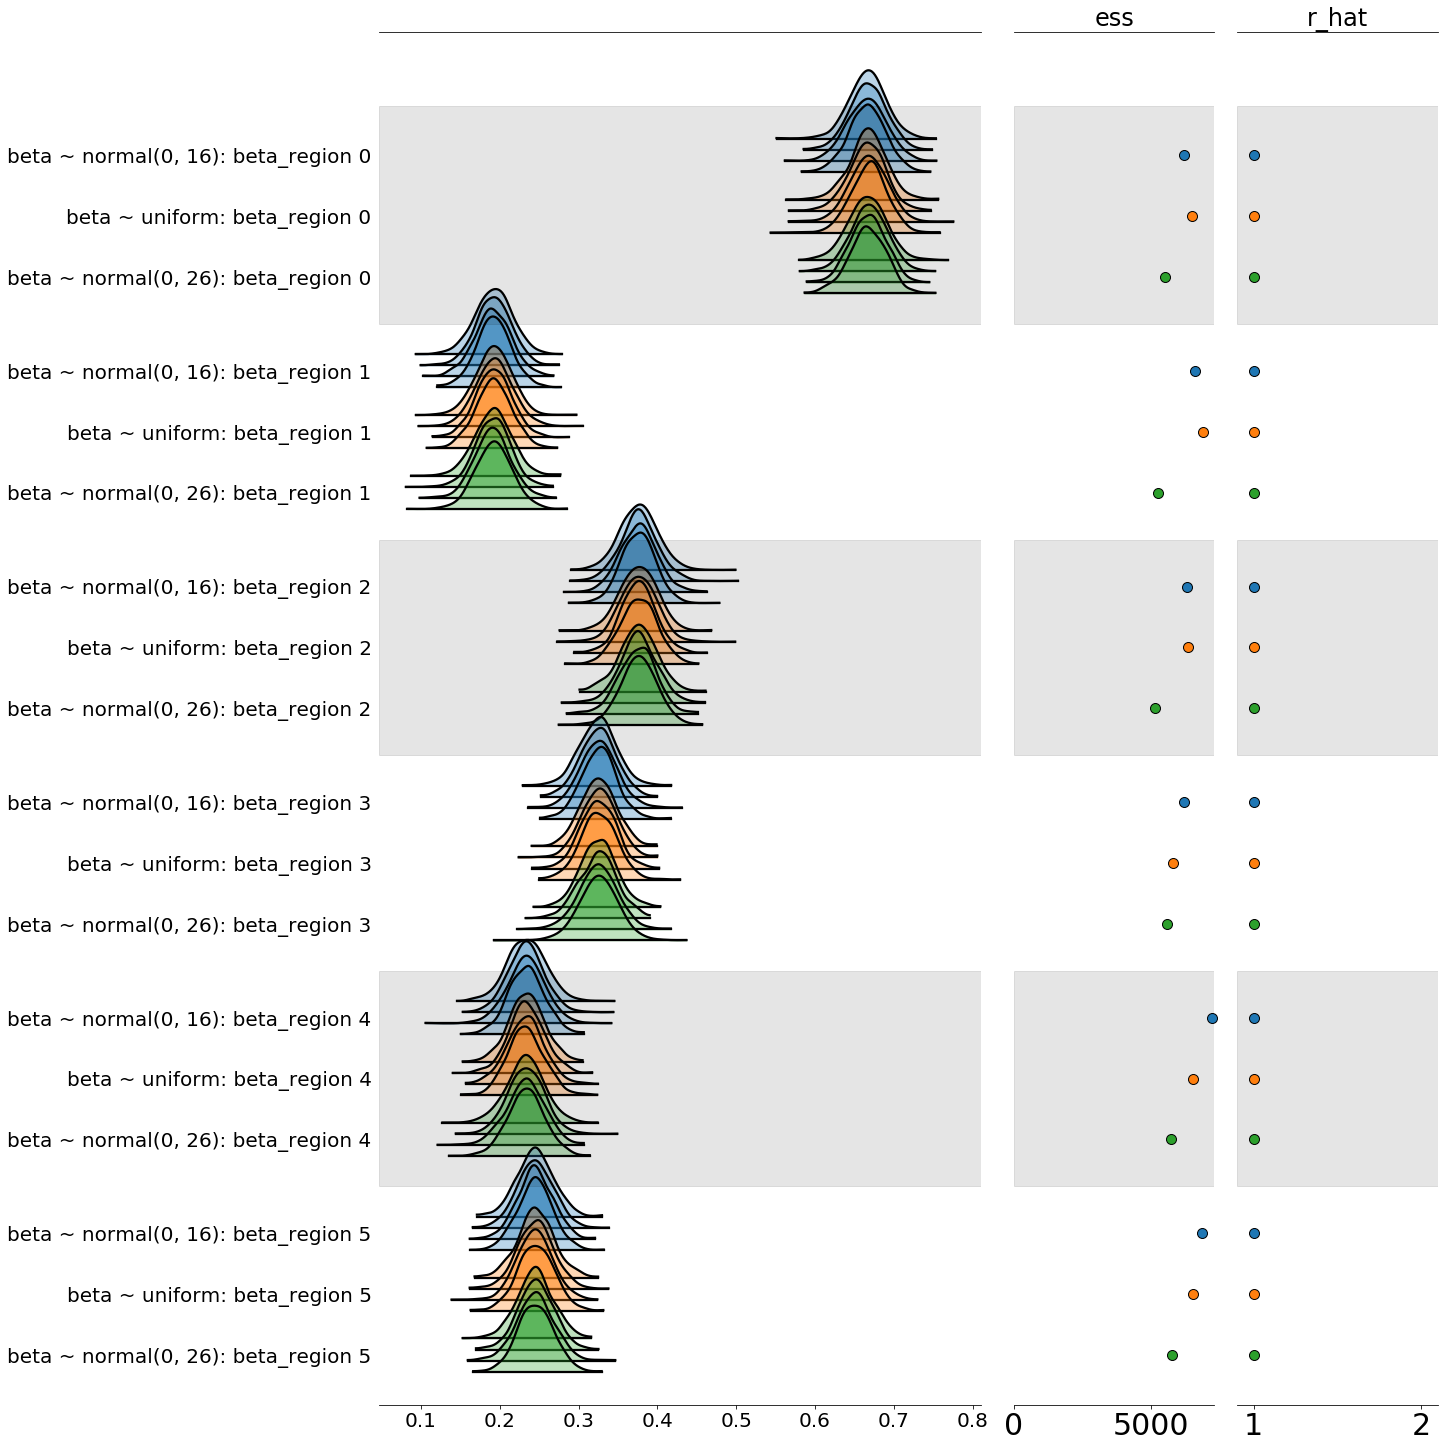

In [203]:
_ = az.plot_forest(
    [hier_fit, hier_fit_uniform, hier_fit_tau26], 
    model_names=["beta ~ normal(0, 16)", "beta ~ uniform", "beta ~ normal(0, 26)",], var_names=["beta_region"], markersize=10,
    kind='ridgeplot', ridgeplot_overlap=3, ridgeplot_alpha=0.3, r_hat=True, ess=True, figsize=(20, 20), textsize=30
)

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.savefig("sensitivity_hier.png")

## 4. Comparing the models

First we compare the models based on the diagnostics and convergence results. Secondly, we evaluate the model performances overall and comment on their applicability in our problem. We refer to hierarchical model as H-model and pooled model as P-model.

**Convergence**

Both models perform neatly in terms of convergence. All the parameters obtained, in both cases, $\hat{R} = 1$, which implies convergence. In addition to the quantitive assessment, one can see visually how the chain simulations are stable and the sequences are overlapping (Look at the traceplots 2.IV and 3.IV). We conclude that the mixing and stationarity conditions for robust convergence hold for both models.

**Posterior predictiveness**

The $R^2$ score that is used to evaluate how close the data are to the fitted regression line, was poor for the pooled one. The P-model was not able explain to what extent the variance of year explains the variance of the life expectancy. The H-model outperformed the P-model clearly in this category as we compare the $R^2$ scores listed previously. This is also seen in the posterior predictive checking plots above, where the error plot around the posterior estimates is much wider for P-model than H-model (Look at plots 2.V and 3.V). Therefore, we conclude that the predictiveness performance is extensively better for H-model.

**Sensitivity to chosen priors**

As stated previously in the sensitivity analysis parts. Both models are concluded to be robust so there are no clear winner in this part.

**Applicability to our problem**

We saw that the P-model was very applicable when predicting the global life expectancy. Obivously this happens because the averaging effect of the parameter pooling. The H-model is suitable when the multilevel structure of life-expectancy data is taken into account since clearly there are differences in life expectancy between regions in the world. The hierarchical approach should be the better one here since the regional differences are real.

Furthermore, the H-model includes the superpopulation for the parameters (slope, intercept). This lets us sample the parameters for an unknown region if needed. We believe that sampling from the superpopulation distributions, one could captivate the behaviour of the global life expectancy trends more deeply. This cannot be usually done with the most of the other approaches. 

## 5. Conclusion

### I. Potential improvements

- We could add another level to the model i.e. instead of modelling the overall life expectancy between regions, we could also model the life expectancy between regions and for each region, between genders. It would be interesting to investigate wether or not there are any differences between the genders and the reasons behind the results.

- Studying the dependence between the slope and intercept could be crucial as it might turn out that they are better modeled together than separately. This makes sense, especially in our case: The lower the intercept, the higher the rate of the life expectancy. The regions that have lower baseline due to lower living standards, education or lack of quality health services might be reaching higher life expectancies much faster than the more developed regions. This type of phenomenon is in fact visible in the plot 3.V.

#### II. Main findings

The benefits of the each model depend strongly on the context. If the researcher is happy with a crude estimation of life expectancy, on average, around the globe, then the pooled model is the most straightforward option. Using the bayesian framework is still highly recommended as it allows the researcher to take the uncertainty regarding the parameters into account in a very intuitive way. However, investing time in building a hierarchical model let the researcher to unravel trends more deeply on the region level - yet obtaining some overall picture from the global level trend. We believe this approach could be very powerful tool for organization like WHO as they tend to work with data that has a natural hierarchical sturcture to some extent. In addition to that, WHO should be interested in the underlying populations as they can reveal surprising things and provide great channels for overall monitoring.

This project was a great pedagogical experience and a very compelling way to let us apply our bayesian statistical skills.

# 6. References

[1] https://cran.r-project.org/web/packages/bayesplot/vignettes/visual-mcmc-diagnostics.html

[2] https://www.displayr.com/what-is-effective-sample-size/

[3] https://www.statista.com/statistics/673420/projected-global-life-expectancy/

[4] https://jrnold.github.io/bayesian_notes/mcmc-diagnostics.html